# 3ra Iteración

Tareas:

- Undersampling
    - Sacar 0's
        - Todos
        - Random

In [2]:
# Utilities

%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import json
from datetime import datetime

def date(date):
    return datetime.strptime(date, '%Y-%m-%d %H:%M:%S')

def load_data(filename):
    with open(filename) as f:
        data = sorted([{**e, 'ts': date(e['ts']), 'jots': date(e['jots'])}
                       for e in json.load(f)],
                       key=lambda x: x['ts'])
    for d in data:
        for w in d['wildfires']:
            w['start'] = date(w['start'])
            w['end'] = date(w['end'])
    return data

def cckey(f, *args):
    return '{}{}'.format(str(f), str(args))
_call_cache = {}

def cc(f, *args, debug=False):
    k = cckey(f, args)
    if k in _call_cache:
        return _call_cache[k]
    if debug:
        print('cc(): cache miss')
    r = f(*args)
    _call_cache[k] = r
    return r

In [3]:
d1 = load_data('dataZ1.json')
d2 = load_data('dataZ2.json')
d3 = load_data('dataZ3.json')

In [4]:
started = None
runs = []
for x in d3:
    if x["pse"] >= 100.0:
        if started is None:
            started = x["ts"]
    elif started is not None:
        runs.append((started, x["ts"]))
        started = None
if started is not None:
    runs.append((started, datetime(2017, 12, 31, 23, 59)))

2524.233333333333 84.1411111111111


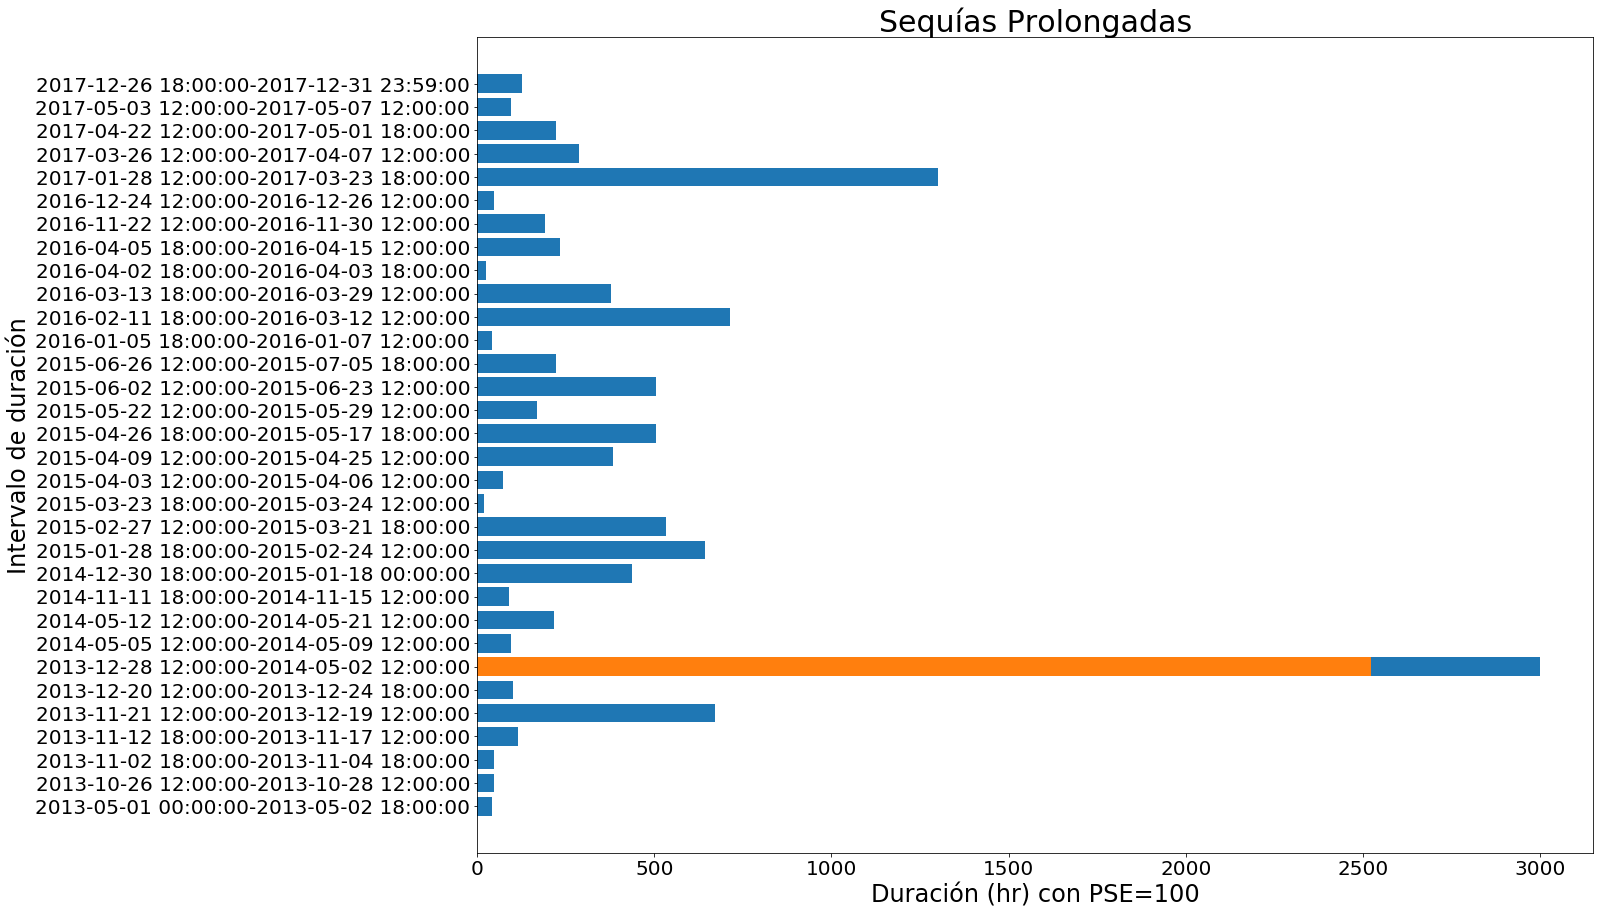

In [43]:
labels = []
durations = []
special = []
for i, (start, end) in enumerate(runs):
    duration = (end-start).total_seconds()/3600
    labels.append(f"{start}-{end}")
    if duration == 3000:
        special.append((datetime(2014,4,12,16,14)-start).total_seconds()/3600)
        print(special[-1], special[-1]*100/3000)
    else:
        special.append(0)
    durations.append(duration)

plt.figure(figsize=(20,15))
plt.tick_params(labelsize=20)
plt.title("Sequías Prolongadas", fontsize=30)
plt.xlabel("Duración (hr) con PSE=100", fontsize=24)
plt.ylabel("Intervalo de duración", fontsize=24)
plt.barh(labels, durations)
plt.barh(labels, special)
plt.savefig('pse-prolongado.png')
plt.show()

**Formato (campos relevantes):**
```
{
    "ts": timestamp,
    "rf": risco,
    "tmp": temperature [C],
    "hum": humidity [%],
    "prec": precipitation (day) [mm],
    "prec7": precipitation (week) [mm],
    "prec30": precipitation (month) [mm],
    "wnd": wind speed [km/h],
    "julio": julio,
    "jots": original timestamp (julio),
    "wildfires": [
        {
            "lat": latitude,
            "lon": longitude,
            "start": timestamp (wildfire start),
            "duration": wildfire duration [hour],
            "cause": cause classification,
            "distance_to": {
                station_code: distance [mt]
            },
            "end": wildfire extintion (start + duration)
        },
        ...
    ],
    
}
```

**Notas:**
- Cuando no se sabe la duración, o es <1hora, por defecto se considera de 1 hora
- Sólo hay una estación disponible a la fecha: "330007"


In [6]:
# Show format (find one with len(wildfires) > 0)
for d in d3:
    if len(d['wildfires']) > 0:
        print(d)
        break

{'ts': datetime.datetime(2013, 8, 23, 22, 0), 'A': 1.5, 'pse': 70.85959260720432, 'rb': 0.576157771246545, 'rf': 0.29432904512575503, 'tmp': 8.4, 'hum': 88.0, 'prec': 0.0, 'prec7': 0.0, 'prec30': 31.4, 'wnd': 5.0, 'wildfires': [{'lat': -33.07972222222222, 'lon': -71.59805555555555, 'start': datetime.datetime(2013, 8, 23, 22, 0), 'duration': 59.6, 'cause': '2.1.1. Pirómano (insano mental que disfruta del fuego)', 'distance_to': {'330007': 3985.53936753603}, 'end': datetime.datetime(2013, 8, 26, 9, 36)}], 'julio': 3.1683316350490207, 'jots': datetime.datetime(2013, 8, 23, 22, 0)}


De la primera iteración se sabe que cada zona tiene una cantidad asociada de incendios:
- Zona 1: 20
- Zona 2: 85
- Zona 3: 436

En esta iteración, se pueden repetir los incendios por cada instancia de datos capturados ya que ahora se sabe la duración de cada incendio:

In [7]:
def print_wildfire_stats(z, tag):
    # Zone 'z' data
    print('Total Zona {}:'.format(tag), end=' ')
    print(sum(len(d['wildfires']) for d in z))

print_wildfire_stats(d1, 1)
print_wildfire_stats(d2, 2)
print_wildfire_stats(d3, 3)

Total Zona 1: 81
Total Zona 2: 1196
Total Zona 3: 5905


**Nota:**
Hay ocasiones en que los incendios duran poco más de 1 mes. Debieran ser acortados?

## Análisis de distribución de distancias

In [8]:
def plot_distance_bar(z):
    dist_tab = {}
    for d in z:
        for w in d['wildfires']:
            k = round(w['distance_to']['330007'])
            if k in dist_tab:
                dist_tab[k] += 1
            else:
                dist_tab[k] = 1

    dist_x = np.array([x for x in dist_tab.keys()])
    dist_y = np.array([y for y in dist_tab.values()])
    
    avg = sum(dist_x * dist_y) / sum(dist_y)
    
    plt.bar(x=dist_x, width=1000, height=dist_y)
    plt.xlabel('Distance [m]')
    plt.ylabel('Occurrences')
    print('Distance Average: {}m'.format(round(avg, 2)))
    plt.show()

Zone 1
Distance Average: 1008.63m


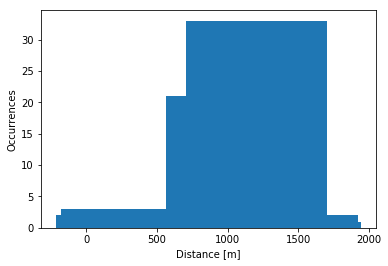

Zone 2
Distance Average: 3296.51m


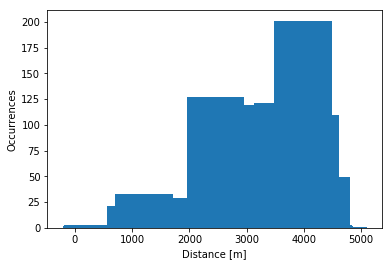

Zone 3
Distance Average: 5822.16m


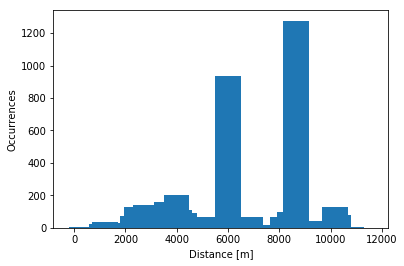

In [9]:
print('Zone 1')
plot_distance_bar(d1)

print('Zone 2')
plot_distance_bar(d2)

print('Zone 3')
plot_distance_bar(d3)

## Análisis de precipitaciones

mean 9.237456037514653
max 203.20000000000002
min 0.0
med 0.2


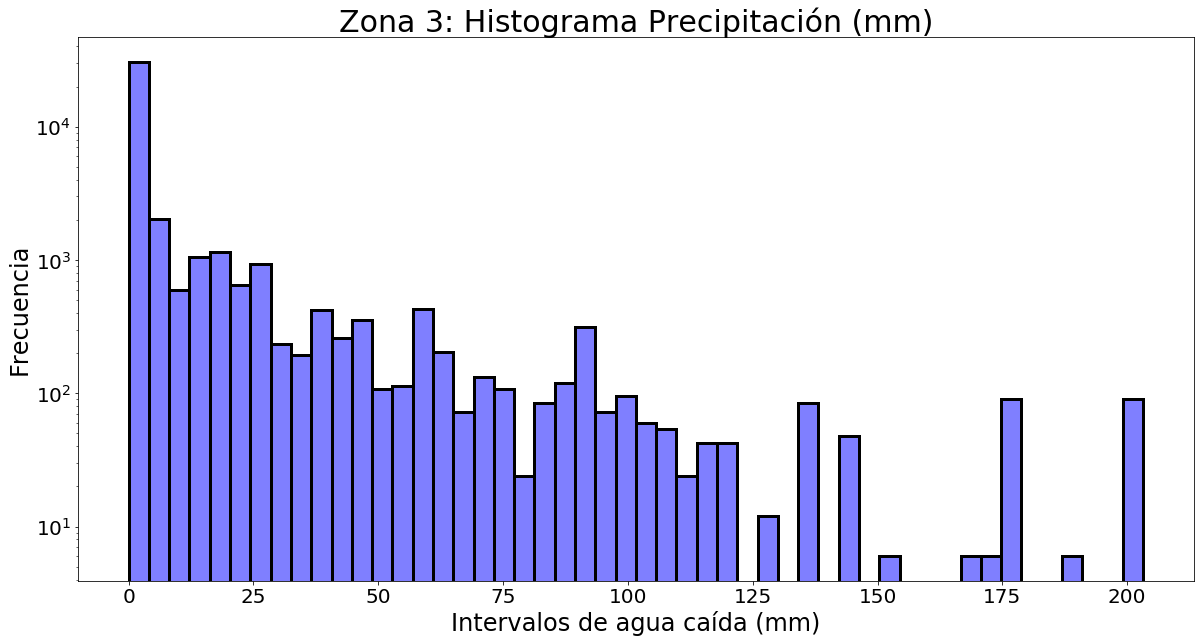

prec>0 25542 62.38%
prec>mean 8148 19.90%
prec>med 19206


In [11]:
precs = [d['prec7'] for d in d3]
p_mean = np.mean(precs)
p_med = np.median(precs)
print('mean', p_mean)
print('max', np.max(precs))
print('min', np.min(precs))
print('med', p_med)
plt.figure(figsize=(20,10))
plt.tick_params(labelsize=20)
plt.title("Zona 3: Histograma Precipitación (mm)", fontsize=30)
plt.xlabel("Intervalos de agua caída (mm)", fontsize=24)
plt.ylabel("Frecuencia", fontsize=24)
plt.hist(precs, 50, log=True, edgecolor="black", lw=3, fc=(0, 0, 1, 0.5))
plt.savefig('prec7-histogram.png')
plt.show()

pgt0 = len([d for d in d3 if d['prec7'] > 0])
pgtm = len([d for d in d3 if d['prec7'] > p_mean])
pgtM = len([d for d in d3 if d['prec7'] > p_med])

print('prec>0', pgt0, '{0:.2f}%'.format(pgt0*100 / len(d3)))
print('prec>mean', pgtm, '{0:.2f}%'.format(pgtm*100 / len(d3)))
print('prec>med', pgtM)

## Análisis 30/30/30

In [12]:
list303030 = [d for d in d3 if d['tmp'] >= 30 and d['hum'] <= 30 and d['wnd'] >= 16.2]
print('30/30/30', len(list303030), '{0:.2}'.format(len(list303030)*100 / len(d3)))

30/30/30 4 0.0098


### Dato anecdótico

In [13]:
print([len(d['wildfires']) for d in d3 if  d['tmp'] >= 30])

[0, 0, 0, 0, 5, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 2, 1, 2, 1, 1, 2, 2, 2, 1, 1, 1, 2, 1, 0, 0, 1, 3]


In [14]:
print([len(d['wildfires']) for d in d3 if  d['tmp'] >= 25 and d['hum'] <= 30 and d['wnd'] >= 10.2])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 3, 3, 4, 3, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 2, 0, 2, 1, 2, 1, 1, 1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 2, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Wind


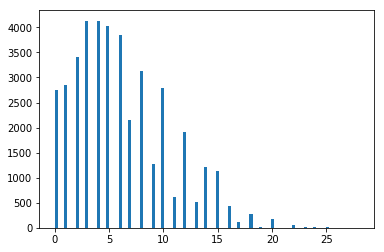

mean 6.135091832747167
max 28.0
min 0.0


In [15]:
print('Wind')
wnd = [d['wnd'] for d in d3]
plt.hist(wnd, 100)
plt.show()

print('mean', np.mean(wnd))
print('max', np.max(wnd))
print('min', np.min(wnd))

*Buscar visualización que permita comparar las 3 variables*

In [12]:
len([d for d in d3 if d['wnd'] >= 25])

18

## Análisis de ocurerncia de incendios

Se obtiene visualmente que la mayoría de los incendios ocurren en el período *Nov-May*.

[http://memoria.rcastill.me/memviz/](http://memoria.rcastill.me/memviz/)

**Cantidad de incendios por hora (cuando hay incendios):**

In [16]:
def plot_wild_count_bar(z):
    wild_tab = {}
    for d in z:
        l = len(d['wildfires'])
        if l > 0:
            if l in wild_tab:
                wild_tab[l] += 1
            else:
                wild_tab[l] = 1

    wild_x = np.array([x for x in wild_tab.keys()])
    wild_y = np.array([y for y in wild_tab.values()])
    
    avg = sum(wild_x * wild_y) / sum(wild_y)
    
    plt.bar(x=wild_x, height=wild_y)
    plt.xticks(wild_x)
    plt.xlabel('Wildfires [unit]')
    plt.ylabel('Occurrences')
    print('Wildfire Count Average: {} wildfires'.format(avg))
    plt.show()

def plot_wild_hour_bar(z, filterf=lambda _: True):
    wild_tab = {}
    for d in z:
        for w in d['wildfires']:
            if filterf(w):
                k = w['start'].hour
                if k in wild_tab:
                    wild_tab[k] += 1
                else:
                    wild_tab[k] = 1

    wild_x = np.array([x for x in wild_tab.keys()])
    wild_y = np.array([y for y in wild_tab.values()])
    
    avg = sum(wild_x * wild_y) / sum(wild_y)
    
    plt.bar(x=wild_x, height=wild_y)
    plt.xticks(wild_x)
    plt.xlabel('Wildfire Start (hour)')
    plt.ylabel('Occurrences')
    print('Wildfire Start Average: {}hrs'.format(round(avg, 2)))
    plt.show()

Zone 1
Wildfire Count Average: 1.0 wildfires


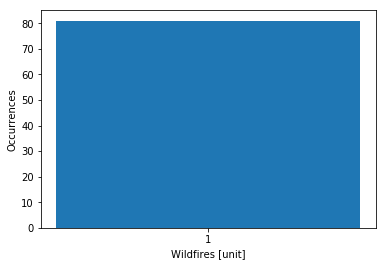

Zone 2
Wildfire Count Average: 1.2791443850267379 wildfires


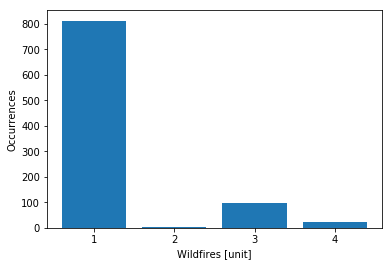

Zone 3
Wildfire Count Average: 1.2767567567567568 wildfires


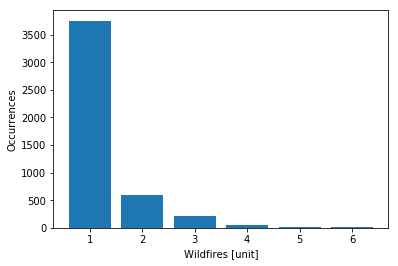

In [17]:
print('Zone 1')
plot_wild_count_bar(d1)

print('Zone 2')
plot_wild_count_bar(d2)

print('Zone 3')
plot_wild_count_bar(d3)

**Distribución horaria de incendios**

Zone 1
Wildfire Start Average: 10.81hrs


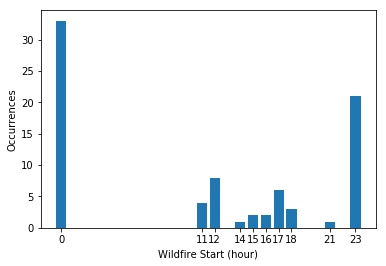

Zone 2
Wildfire Start Average: 15.29hrs


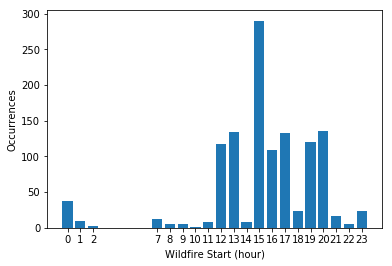

Zone 3
Wildfire Start Average: 15.19hrs


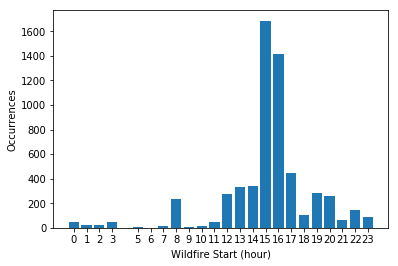

In [18]:
print('Zone 1')
plot_wild_hour_bar(d1)

print('Zone 2')
plot_wild_hour_bar(d2)

print('Zone 3')
plot_wild_hour_bar(d3)

**Análisis de causas**

In [16]:
causes = set()
# Z3 es superset
for d in d3:
    for w in d['wildfires']:
        causes.add(w['cause'])
print('Total:', len(causes))
for c in causes:
    print(c)

Total: 18
1.7.3. Accidente o incendio de vehí­culo en tránsito
2.1.1. Pirómano (insano mental que disfruta del fuego)
1.8.2. Quema legal de aserrí­n o aserrí­n encendido
2.1.11. Otros intencionales no clasificados
1.4.5. Niños jugando con fuego
1.8.1. Quema de basuras  desechos vegetales u otros no clasificados (distintos de vertederos o basurales autorizados)
1.4.1. Uso de fuego para actividades recreativas en áreas no habilitadas  (excursionistas  paseantes  asados)
1.10.5. Soldadura y montaje de estructuras varias (torres de alta tensión  oleoductos  etc.)
1.1.5. Quema legal de habilitación de terreno forestal (quema para forestación)
1.1.2. Quema ilegal de desechos de cosecha forestal (quema para reforestación)
4.1.1. Desconocida (se investiga pero no es posible establecer la causa origen)
1.8.14. Encendido de vertederos o basurales autorizados 
1.9.4. Corte de cable por otro accidente o acción no clasificada
3.1.1. Caí­da de rayo
1.1.19. Chispa  maquinaria en faena forestal (skidd

A partir de lo anterior se puede discernir entre *legal* e *ilegal*:

In [25]:
def islegal(w):
    return w['cause'].split()[0] in ['1.8.2.',
                                     '1.1.5.',
                                     '1.8.14.',
                                     '1.8.1.']

In [26]:
print('Legal/Ilegal Ratio:', end=' ')
legal = 0
ilegal = 0
for d in d3:
    for w in d['wildfires']:
        if islegal(w):
            legal += 1
        else:
            ilegal += 1
print('{}/{} ({}%)'.format(legal, ilegal, legal*100/ilegal))

Legal/Ilegal Ratio: 422/5483 (7.6965165055626485%)


**Distribución horaria de incendios (sólo ilegales)**

Zone 1
Wildfire Start Average: 10.81hrs


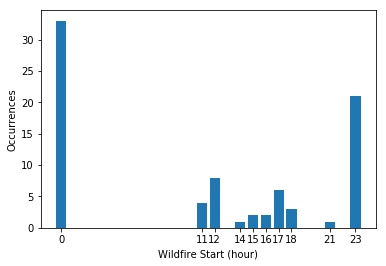

Zone 2
Wildfire Start Average: 15.35hrs


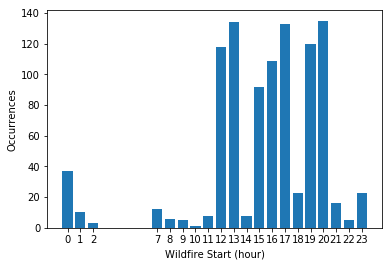

Zone 3
Wildfire Start Average: 15.49hrs


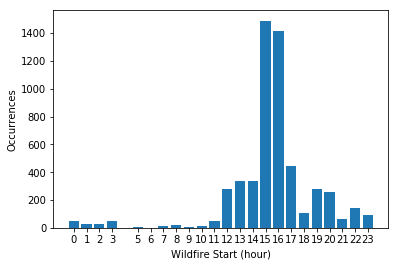

In [27]:
print('Zone 1')
plot_wild_hour_bar(d1, lambda w: not islegal(w))

print('Zone 2')
plot_wild_hour_bar(d2, lambda w: not islegal(w))

print('Zone 3')
plot_wild_hour_bar(d3, lambda w: not islegal(w))

*No existe una variación considerable al considerar la combinación de casos*

In [28]:
def only_legal(d):
    '''
    Obtener instancias en las que existe sólo 1 incendio
    y es legal
    '''
    if len(d['wildfires']) > 0:
        if len([w for w in d['wildfires'] if islegal(w)]) == len(d['wildfires']):
            return True
    return False

def least_legal(d):
    '''
    Obtener instancias en las que el incendio más cercano
    es legal
    '''
    if len(d['wildfires']) > 0:
        least = d['wildfires'][0]['distance_to']['330007']
        legal = islegal(d['wildfires'][0])
        for w in d['wildfires'][1:]:
            if w['distance_to']['330007'] < least:
                least = w['distance_to']['330007']
                legal = islegal(w)
        return legal
    return False


In [29]:
only_legal_count = len([d for d in d3 if only_legal(d)])
print('No. only legal wildfires:', only_legal_count)

least_legal_count = len([d for d in d3 if least_legal(d)])
print('No. wildfires with least_legal_count:', least_legal_count)

No. only legal wildfires: 400
No. wildfires with least_legal_count: 420


## Criterios de etiquetado

Considerando los datos anteriores se desarrolla el siguiente criterio:

- Si la quema más cercana es legal, la etiqueta será 0.0
    - Se usa este método ya que, aunque más agresivo, la diferencia es poca
- Se asume que de noche las condiciones no son propicias para que inicie un incendio
    - Se propone una discusión al respecto dado que existen instancias en las que si se dan incendios
    - Para Z1: `01:00-10:00`
    - Para Z2: `01:00-06:00`
    - Para Z3: `01:00-10:00`
- Cuando hay incendios:
    - Si la cantidad de incendios es >ceil(avg), la etiqueta será 1.0
    - Luego, si la distancia min <avg, la etiqueta será 1.0
    - Luego, si la distancia min >avg, la etiqueta se comportará de manera lineal desde 0.9 a 0.99
- Cuando no hay incendios:
    - Se hace una ponderación de los índices de incendios: 0.9 * (0.8 * rf + julio * 0.2/100); esto permite que los valores fluctúen entre 0 y 0.9
- Si es necesario, se ejecutará undersampling, utilizando sólo datos de noviembre a mayo

In [30]:
def wild_count_dist_mean(z):
    wild_count = []
    wild_dist = []
    for d in z:
        l = len([w for w in d['wildfires']
                 if not islegal(w)])
        if l > 0:
            wild_count.append(l)
        wild_dist.extend([w['distance_to']['330007']
                          for w in d['wildfires']])
    return np.mean(wild_count), np.mean(wild_dist)

In [31]:
# Get needed variables
avgc1, avgd1 = wild_count_dist_mean(d1)
avgc2, avgd2 = wild_count_dist_mean(d2)
avgc3, avgd3 = wild_count_dist_mean(d3)

In [32]:
# y - y1 = m(x - x1)
# y = mx + (y1 - m*x1)
def mk_wildfire_line(z, avg):
    # max distance
    x1 = avg
    y1 = 0.9
    
    # minimum distance
    x2 = avg
    y2 = 0.99
    
    for d in z:
        for w in d['wildfires']:
            dist = w['distance_to']['330007']
            if dist >= x1:
                x1 = dist
    
    m = (y2 - y1) / (x2 - x1)
    y0 = y1 - m * x1
    
    return lambda x: m * x + y0

def indcomb(rf, julio):
    if rf > 1:
        rf = 1
    elif rf < 0:
        rf = 0
    if julio > 100:
        julio = 100
    elif julio < 0:
        julio = 0
    return 0.9 * (0.8 * rf + 0.2 * (julio/100))

def mark(d, wline, nightfr, nightto, avgc, avgd):
    notlegal = [w for w in d['wildfires'] if not islegal(w)]
    if len(notlegal) > 0:
        min_dist = min([w['distance_to']['330007'] for w in notlegal])
    else:
        min_dist = -1
    if least_legal(d):
        d['mark'] = 0.0
    elif d['ts'].hour >= nightfr and d['ts'].hour <= nightto:
        d['mark'] = 0.0
    elif len(notlegal) > int(np.ceil(avgc)):
        d['mark'] = 1.0
    elif min_dist >= 0 and min_dist < avgd:
        d['mark'] = 1.0
    elif min_dist >= avgd:
        d['mark'] = wline(min_dist)
    else:
        if d['jots'] == d['ts']:
            d['mark'] = indcomb(d['rf'], d['julio'])
        else:
            d['mark'] = 0.9 * min(max(0, d['rf']), 1)
    return d

def marked(z, nightfr, nightto, avgc, avgd):
    wline = mk_wildfire_line(z, avgd)
    return [mark(d.copy(), wline, nightfr, nightto, avgc, avgd) for d in z]

In [33]:
# hubiera sido interesante agregar criterio 30/30/30
# pero los casos son mínimmos

def mark2(d):
    if d['prec7'] > p_mean:
        d['mark'] = 0
    elif d['prec7'] > 0:
        d['mark'] = 0.5
    elif len(d['wildfires']) > 0:
        d['mark'] = 1
    return d

def marked2(z):
    l1 = [mark2(d.copy()) for d in z]
    return [d for d in l1 if 'mark' in d]

In [34]:
# Dar prioridad a wildfire
# hubiera sido interesante agregar criterio 30/30/30
# pero los casos son mínimmos

def mark3(d):
    if len(d['wildfires']) > 0:
        d['mark'] = 1
    elif d['prec7'] > p_mean:
        d['mark'] = 0
    elif d['prec7'] > 0:
        d['mark'] = 0.5
    return d

def marked3(z):
    l1 = [mark3(d.copy()) for d in z]
    return [d for d in l1 if 'mark' in d]

Filtro:

- Usar sólo datos de 2013-2016
- Usar sólo datos de [nov-may]

In [35]:
next(d for d in d3 if len(d['wildfires']) > 0)

{'ts': datetime.datetime(2013, 8, 23, 22, 0),
 'A': 1.5,
 'pse': 70.85959260720432,
 'rb': 0.576157771246545,
 'rf': 0.29432904512575503,
 'tmp': 8.4,
 'hum': 88.0,
 'prec': 0.0,
 'prec7': 0.0,
 'prec30': 31.4,
 'wnd': 5.0,
 'wildfires': [{'lat': -33.07972222222222,
   'lon': -71.59805555555555,
   'start': datetime.datetime(2013, 8, 23, 22, 0),
   'duration': 59.6,
   'cause': '2.1.1. Pirómano (insano mental que disfruta del fuego)',
   'distance_to': {'330007': 3985.53936753603},
   'end': datetime.datetime(2013, 8, 26, 9, 36)}],
 'julio': 3.1683316350490207,
 'jots': datetime.datetime(2013, 8, 23, 22, 0)}

In [36]:
def Y(d):
    return d['ts'].year

def filter1(data):
    def nov2may(d):
        def M(d):
            return d['ts'].month
        return M(d) >= 11 or (M(d) >= 1 and M(d) <= 5)

    return [d.copy() for d in data
            if Y(d) >= 2013 and Y(d) <= 2016 and
            nov2may(d)]

def filter2(data):
    return [d.copy() for d in data if Y(d) > 2016]

In [37]:
# Training data
td1 = marked(filter1(d1), 1, 10, avgc1, avgd1)
td2 = marked(filter1(d2), 1, 6, avgc2, avgd2)
td3 = marked(filter1(d3), 1, 10, avgc3, avgd3)

In [38]:
# testing data
t3 = filter2(d3)
print(len(t3))

8760


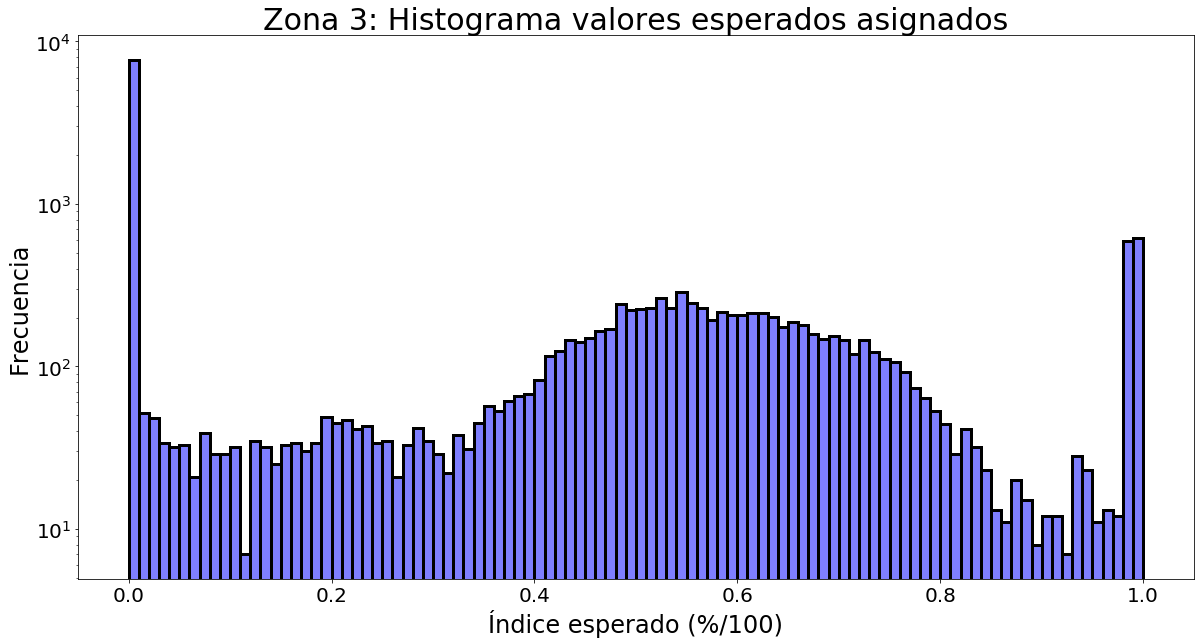

In [40]:
plt.figure(figsize=(20,10))
plt.tick_params(labelsize=20)
plt.title("Zona 3: Histograma valores esperados asignados", fontsize=30)
plt.xlabel("Índice esperado (%/100)", fontsize=24)
plt.ylabel("Frecuencia", fontsize=24)
plt.hist([d["mark"] for d in td3], 100, log=True, edgecolor="black", lw=3, fc=(0, 0, 1, 0.5))
#plt.hist([d['mark'] for d in td3], 50)
plt.savefig('iter2-mark-hist.png')
plt.show()

Se deben sacar 0s

In [33]:
def mcount(dat, v):
    return len([d for d in dat if d['mark'] == v])

In [34]:
print('zcount', cc(mcount, td3, 0.0))
print('ocount', cc(mcount, td3, 1.0))
print('remove', cc(mcount, td3, 0.0) - cc(mcount, td3, 1.0))

zcount 7546
ocount 615
remove 6931


In [35]:
len(td3)

17496

In [36]:
print('Data used: {0:.2f}%'.format(len(td3) * 100 / len(d3)))

Data used: 42.73%


In [37]:
remove = cc(mcount, td3, 0.0) - cc(mcount, td3, 1.0)

In [38]:
zeroes = [d.copy() for d in td3 if d['mark'] == 0]
step = int(6931 / 615)
stripz = [d for i, d in enumerate(zeroes) if i % step == 0]
print(len(stripz))

686


In [39]:
td30 = [d.copy() for i, d in enumerate(td3) if d['mark'] > 0 or d in stripz]

In [40]:
len(td30)*100/len(d3)

25.976944118796403

In [75]:
len([d for d in td30 if d["mark"] == 0.0])

686

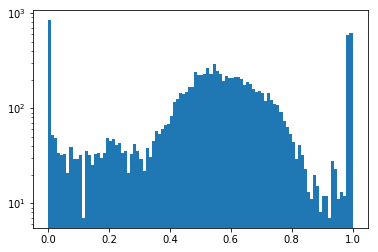

In [100]:
plt.hist([d['mark'] for d in td30], 100, log=True)
plt.show()

In [42]:
print('Data used: {0:.2f}%'.format(len(td30) * 100 / len(d3)))

Data used: 25.98%


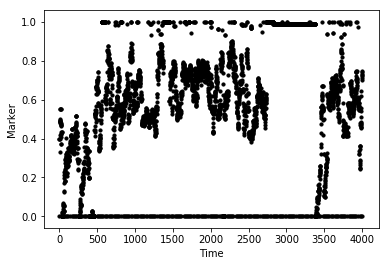

In [43]:
for i, d in enumerate(td30[:4000]):
    plt.scatter(i, d['mark'], color='black', s=10, marker='o')

plt.xlabel('Time')
plt.ylabel('Marker')
plt.show()

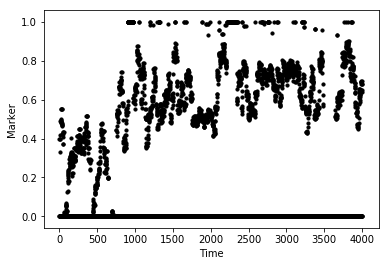

In [44]:
# Draw first 200 expected markers
for i, d in enumerate(td3[:4000]):
    plt.scatter(i, d['mark'], color='black', s=10, marker='o')
plt.xlabel('Time')
plt.ylabel('Marker')
plt.show()

Convert data to tensor representation

In [45]:
import torch

def to_tensor_x(data):
    return torch.FloatTensor(
        [[d['ts'].month, d['tmp'],
          d['hum'], d['prec7'],
          d['wnd']] for d in data])

def to_tensor_y(data):
    return torch.FloatTensor([[d['mark']] for d in data])

def to_data(data, predicted):
    for d, y in zip(data, predicted):
        yield {
            **d,
            'ind': y.item()
        }

def mean_std(data):
    return np.mean(data.numpy(), axis=0, keepdims=True),\
        np.std(data.numpy(), axis=0, keepdims=True)
        
def std(data, means=None, std=None):
    '''
    Standarize
    '''
    if means is None:
        means, std = mean_std(data)
    return torch.from_numpy((data.numpy() - means) / std)

def norm(data):
    '''
    Normalize
    '''
    mins = np.min(data.numpy(), axis=0, keepdims=True)
    maxs = np.max(data.numpy(), axis=0, keepdims=True)
    return torch.from_numpy((data.numpy()-mins)/(maxs-mins))

In [46]:
# train data for Z1
x1 = to_tensor_x(td1)
y1 = to_tensor_y(td1)

# train data for Z2
x2 = to_tensor_x(td2)
y2 = to_tensor_y(td2)

# train data for Z3
x3 = to_tensor_x(td3)
y3 = to_tensor_y(td3)

x30 = to_tensor_x(td30)
y30 = to_tensor_y(td30)

In [47]:
class LinearModel(torch.nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        # 7 inputs, 1 output
        self.linear = torch.nn.Linear(5, 1)
        #self.layer2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        y_pred = self.linear(x)
        #y_pred = self.layer2(torch.nn.ReLU()(self.linear(x)))
        return y_pred

class NonLinearModel(torch.nn.Module):
    def __init__(self, hidden_dim=2):
        super(NonLinearModel, self).__init__()
        self.layer1 = torch.nn.Linear(5, hidden_dim)
        self.layer2 = torch.nn.Linear(hidden_dim, 1)
    
    def forward(self, x):
        return self.layer2(torch.nn.ReLU()(self.layer1(x)))

mse_loss = torch.nn.MSELoss(size_average=False)

def sgd(model_params):
    return torch.optim.SGD(model_params, lr=0.01)

def adam(model_params):
    return torch.optim.Adam(model_params, lr=0.01)

def train(model, train_x, train_y, *, iterations=500, criterion=mse_loss, mkoptimizer=sgd):
    '''
    Example:
        train(LinearModel(), x, y, criterion=torch.nn.SmoothL1Loss(),
            mkoptimizer=lambda p: torch.optim.Adam(p, lr=0.01))
    '''
    optimizer = mkoptimizer(model.parameters())
    for epoch in range(iterations):
        y_pred = model(train_x)
        loss = criterion(y_pred, train_y)
        plt.scatter(epoch, loss.data.item(), color='r', s=10, marker='o')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    plt.show()
    return model

def test_model(model, data, *, extract=2000, xtransform=std):
    x = xtransform(to_tensor_x(data))
    for i, d in enumerate(data[:extract]):
        color = 'r' if len(d['wildfires']) > 0 else 'black'
        plt.scatter(i, d['mark'], color=color, s=10, marker='o')
    for i, y in enumerate(model(x)[:extract]):
        plt.scatter(i, y.item(), color='b', s=10, marker='o')
    plt.show()

def test_model2(model, data, *, xtransform=std):
    x = xtransform(to_tensor_x(data))
    for i, y in enumerate(model(x)):
        plt.scatter(i, y.item(), color='b', s=10, marker='o')
    plt.show()    

/Users/Rodolfo/.virtualenvs/jupyter/lib/python3.7/site-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


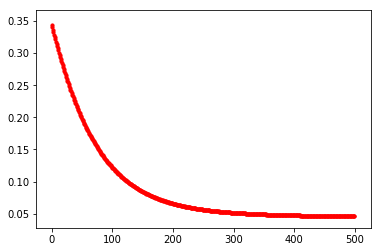

In [48]:
means3, std3 = mean_std(x3)
m3lin = train(LinearModel(), std(x3), y3, criterion=torch.nn.SmoothL1Loss())

In [49]:
print(means3)
print(std3)

[[ 5.9396434 15.704431  74.20222    3.554527   6.3840876]]
[[ 4.135555   3.8999004 18.560207  14.115811   4.19429  ]]


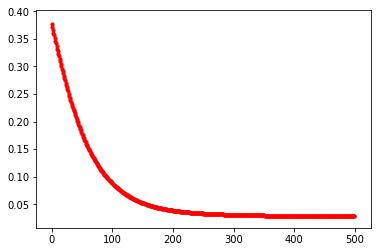

In [50]:
means30, std30 = mean_std(x30)
m30lin = train(LinearModel(), std(x30), y30, criterion=torch.nn.SmoothL1Loss())

In [51]:
print(means30)
print(std30)

[[ 6.012881 16.695087 71.077286  3.702586  6.940203]]
[[ 4.1482115  4.111962  19.259232  14.661884   4.0224233]]


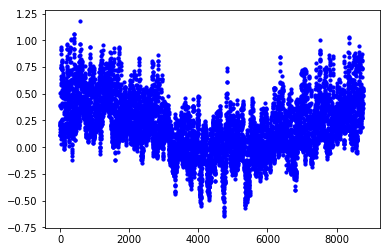

In [52]:
test_model2(m3lin, t3, xtransform=lambda x: std(x, means3, std3))

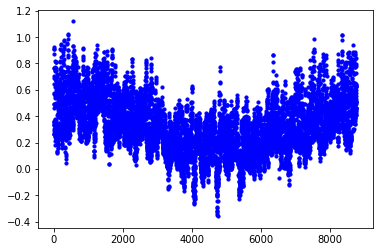

In [53]:
test_model2(m3lin, t3)

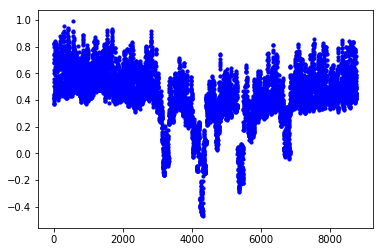

In [49]:
test_model2(m30lin, t3, xtransform=lambda x: std(x, means30, std30))

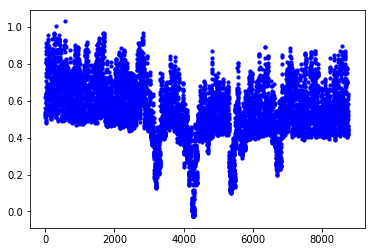

In [222]:
test_model2(m30lin, t3)

In [54]:
# save output
def save(z, x, model, filename, xtrans=std):
    with open(filename, 'w') as f:
        #y = model(xtrans(x))
        y = model(xtrans(to_tensor_x(z)))
        d = [ _ for _ in to_data(z, y)]
        json.dump(d, f, default=lambda x: str(x))
        print('Written to {}'.format(filename))

In [242]:
save(d3, x3, m3lin, 'm3lin_stripped.json', xtrans=lambda x:std(x, means3, std3))

Written to m3lin_stripped.json


In [82]:
save(d3, x30, m30lin, "m30lin.json", xtrans=lambda x: std(x, means30, std30))

Written to m30lin.json


In [112]:
m30lin.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.0051,  0.1436,  0.0550, -0.0799,  0.0383]])),
             ('linear.bias', tensor([0.5400]))])

In [55]:
'''    return torch.FloatTensor(
        [[d['ts'].month, d['tmp'],
          d['hum'], d['prec7'],
          d['wnd']] for d in data])
'''

v303030 = torch.FloatTensor([[1, 30, 30, 0, 30]])
m3lin(std(v303030, means3, std3))

tensor([[1.2216]], grad_fn=<AddmmBackward>)

## Ejemplo minimalista

In [56]:
m3 = marked2(d3)
m32 = marked2(filter1(d3))

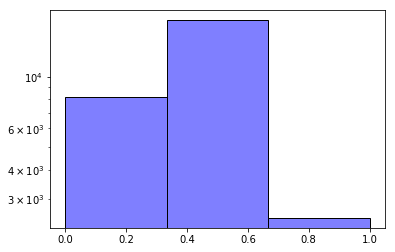

In [115]:
plt.hist([d['mark'] for d in m3], 3, edgecolor="black", lw=1, fc=(0, 0, 1, .5), log=True)
plt.show()

#plt.hist([d['mark'] for d in m32], 50)
#plt.show()

In [58]:
print('m3')
print(len([d for d in m3 if d['mark'] == 0]))
print(len([d for d in m3 if d['mark'] == 0.5]))
print(len([d for d in m3 if d['mark'] == 1]))
print()
print('m32')
print(len([d for d in m32 if d['mark'] == 0]))
print(len([d for d in m32 if d['mark'] == 0.5]))
print(len([d for d in m32 if d['mark'] == 1]))

m3
8148
17394
2488

m32
1506
8490
1065


In [59]:
print('m3 stats', len(m3), '{0:.2f}%'.format(len(m3)*100/len(d3)))
print('m32 stats', len(m32), '{0:.2f}%'.format(len(m32)*100/len(d3)))

m3 stats 28030 68.46%
m32 stats 11061 27.01%


In [60]:
mx3 = to_tensor_x(m3)
my3 = to_tensor_y(m3)

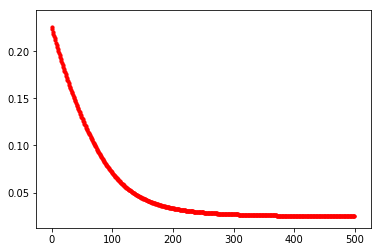

In [61]:
mmeans3, mstd3 = mean_std(mx3)
mmlin3 = train(LinearModel(), std(mx3), my3, criterion=torch.nn.SmoothL1Loss())

In [62]:
print(mmeans3)
print(mstd3)

[[ 6.766643  13.604312  77.29115   13.492987   5.9561434]]
[[ 3.2112377  4.340112  18.99856   28.030842   4.359292 ]]


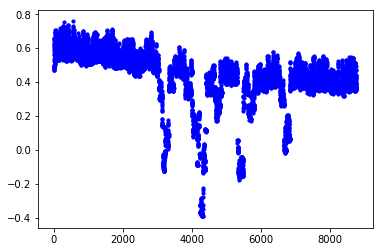

In [112]:
test_model2(mmlin3, t3, xtransform=lambda x: std(x, mmeans3, mstd3))

In [203]:
save(d3, None, mmlin3, 'mm3lin.json', xtrans=lambda x: std(x, mmeans3, mstd3))

Written to mm3lin.json


In [185]:
with open('m3lin_mark.json', 'w') as f:
    json.dump([{'ts': d['ts'], 'mark': d['mark']} for d in td3], f, default=lambda x: str(x))
    print('done')

done


In [116]:
with open('m30lin_mark.json', 'w') as f:
    json.dump([{'ts': d['ts'], 'mark': d['mark']} for d in td30], f, default=lambda x: str(x))
    print('done')

done


In [117]:
with open('mm3lin_mark.json', 'w') as f:
    json.dump([{'ts': d['ts'], 'mark': d['mark']} for d in m3], f, default=lambda x: str(x))
    print('done')

done


In [117]:
m3i = marked3(d3)
m32i = marked3(filter1(d3))

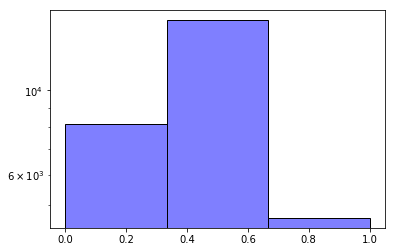

In [118]:
plt.hist([d['mark'] for d in m3i], 3, edgecolor="black", lw=1, fc=(0, 0, 1, .5), log=True)
plt.show()

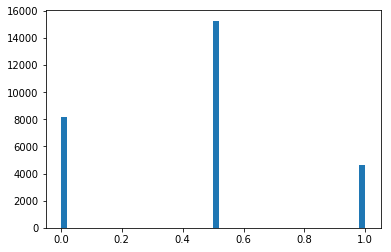

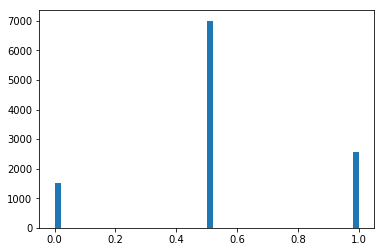

In [65]:
plt.hist([d['mark'] for d in m3i], 50)
plt.show()

plt.hist([d['mark'] for d in m32i], 50)
plt.show()

In [66]:
print('m3i')
print(len([d for d in m3i if d['mark'] == 0]))
print(len([d for d in m3i if d['mark'] == 0.5]))
print(len([d for d in m3i if d['mark'] == 1]))
print()
print('m32i')
print(len([d for d in m32i if d['mark'] == 0]))
print(len([d for d in m32i if d['mark'] == 0.5]))
print(len([d for d in m32i if d['mark'] == 1]))

m3i
8138
15267
4625

m32i
1500
7006
2555


In [67]:
print('m3 stats', len(m3), '{0:.2f}%'.format(len(m3)*100/len(d3)))
print('m32 stats', len(m32), '{0:.2f}%'.format(len(m32)*100/len(d3)))

m3 stats 28030 68.46%
m32 stats 11061 27.01%


In [68]:
mx3i = to_tensor_x(m3i)
my3i = to_tensor_y(m3i)

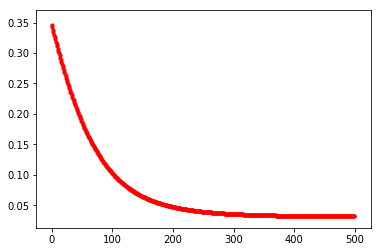

In [69]:
mmeans3i, mstd3i = mean_std(mx3i)
mmlin3i = train(LinearModel(), std(mx3i), my3i, criterion=torch.nn.SmoothL1Loss())

In [70]:
print(mmeans3i)
print(mstd3i)

[[ 6.766643  13.604312  77.29115   13.492987   5.9561434]]
[[ 3.2112377  4.340112  18.99856   28.030842   4.359292 ]]


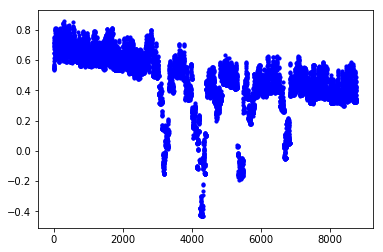

In [198]:
test_model2(mmlin3i, t3, xtransform=lambda x: std(x, mmeans3i, mstd3i))

In [201]:
save(d3, None, mmlin3i, 'mm3lin_i.json', xtrans=lambda x: std(x, mmeans3i, mstd3i))

Written to mm3lin_i.json


In [204]:
with open('mm3lin_i_mark.json', 'w') as f:
    json.dump([{'ts': d['ts'], 'mark': d['mark']} for d in m3i], f, default=lambda x: str(x))
    print('done')

done


In [122]:
def mark4(d):
    if d['prec7'] > p_mean:
        d['mark'] = 0
    elif d['prec7'] > 0:
        d['mark'] = 0.5
    elif len(d['wildfires']) > 0:
        d['mark'] = 1
    return d

def markd(dataset, mark):
    copied = [mark(d.copy()) for d in dataset]
    return [c for c in copied if "mark" in c]

In [191]:
def train_and_save(marker, dataset, *, save_to=None, filter_fn=lambda data: data, equalize_extremes=False):
    marked = markd(filter_fn(dataset), marker)
    plt.hist([d["mark"] for d in marked],
             3, edgecolor="black", lw=1,
             fc=(0, 0, 1, .5), log=True)
    plt.show()
    
    if equalize_extremes:
        zeroes = [m for m in marked if m["mark"] == 0.0]
        zcount = len(zeroes)
        ocount = len([m for m in marked if m["mark"] == 1.0])
        if zcount > ocount:
            remove = zcount - ocount
            step = int(zcount / remove)
            print("Remove", remove)
            print("zcount", zcount)
            print("ocount", ocount)
            print("Step", step)
            stripz = [z for i, z in enumerate(zeroes) if i % step != 0]
            marked = [m.copy() for m in marked if m["mark"] > 0 or m in stripz]

            plt.hist([d["mark"] for d in marked],
                     3, edgecolor="black", lw=1,
                     fc=(0, 0, 1, .5), log=True)
            plt.show()
        else:
            raise RuntimeError("More 1s than 0s")
    
    x = to_tensor_x(marked)
    y = to_tensor_y(marked)
    
    means, the_std = mean_std(x)
    
    model = train(LinearModel(), std(x), y, criterion=torch.nn.SmoothL1Loss())

    if save_to is not None:
        save(dataset, None, model, save_to, xtrans=lambda x:std(x, means, the_std))
    
    return model.state_dict()

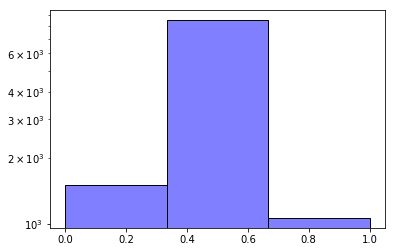

Remove 441
zcount 1506
ocount 1065
Step 3


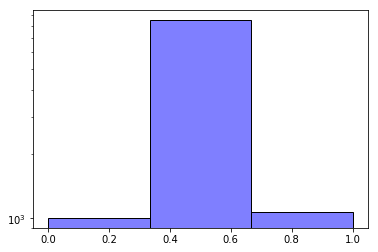

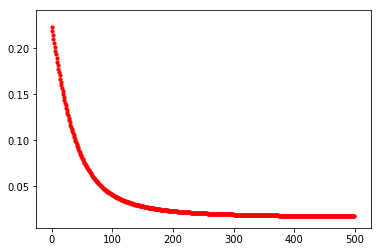

Written to marked2-filter1-values-equalized.json


OrderedDict([('linear.weight',
              tensor([[-0.0405, -0.0864, -0.1261, -0.1160,  0.0040]])),
             ('linear.bias', tensor([0.5003]))])

In [192]:
train_and_save(mark2, d3, filter_fn=filter1, equalize_extremes=True,
               save_to="marked2-filter1-values-equalized.json")

In [184]:
with open("marked2-filter1-values.json") as f:
    huehue = json.load(f)
sum(h["ind"] for h in huehue)/len(huehue)

0.43312832173986354

In [188]:
with open("marked2-filter1-values-equalized.json") as f:
    huehue = json.load(f)
sum(h["ind"] for h in huehue)/len(huehue)

0.4493878786206455

## Análisis lluvia/incendios

In [71]:
rains = [d for d in d3 if d['prec7'] > 0]
print('{} "rains"'.format(len(rains)))

25542 "rains"


In [72]:
rains_w_wildfire = [d['prec7'] for d in d3 if d['prec7'] > 0 and len(d['wildfires']) > 0]
print('{} combis'.format(len(rains_w_wildfire)))

2137 combis


In [73]:
print('combi avg', np.mean(rains_w_wildfire))
print('combi max', np.max(rains_w_wildfire))
print('combi min', np.min(rains_w_wildfire))

combi avg 0.7359382311651849
combi max 26.3
combi min 0.1


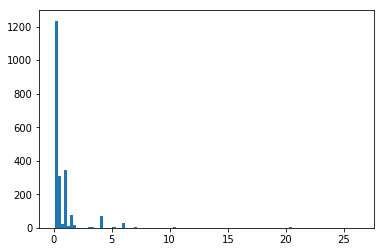

In [74]:
plt.hist(rains_w_wildfire, 100)
plt.show()